In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import time
import argparse
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
args = argparse.Namespace(name = "ConvMixer", 
                          batch_size = 512,
                          scale = 0.75,
                          reprob = 0.25,
                          ra_m = 8,
                          ra_n = 1,
                          jitter = 0.1,
                          hdim = 256,
                          depth = 8,
                          psize = 2,
                          conv_ks = 5,
                          wd = 0.005,
                          clip_norm = 'store_true',
                          epochs = 50,
                          lr_max = 0.05,
                          workers = 2)

In [3]:
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x):
        return self.fn(x) + x

In [4]:
def ConvMixer(dim, depth, kernel_size=5, patch_size=2, n_classes=10):
    return nn.Sequential(
        nn.Conv2d(3, dim, kernel_size=patch_size, stride=patch_size),
        nn.GELU(),
        nn.BatchNorm2d(dim),
        *[nn.Sequential(
                Residual(nn.Sequential(
                    nn.Conv2d(dim, dim, kernel_size, groups=dim, padding="same"),
                    nn.GELU(),
                    nn.BatchNorm2d(dim)
                )),
                nn.Conv2d(dim, dim, kernel_size=1),
                nn.GELU(),
                nn.BatchNorm2d(dim)
        ) for i in range(depth)],
        nn.AdaptiveAvgPool2d((1,1)),
        nn.Flatten(),
        nn.Linear(dim, n_classes)
    )

In [5]:
cifar10_mean = (0.4914, 0.4822, 0.4465)
cifar10_std = (0.2471, 0.2435, 0.2616)

In [ ]:
# augmentation 포함된 변환
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(32, scale=(args.scale, 1.0), ratio=(1.0, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandAugment(num_ops=args.ra_n, magnitude=args.ra_m),
    transforms.ColorJitter(args.jitter, args.jitter, args.jitter),
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std),
    transforms.RandomErasing(p=args.reprob)
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std)
])

In [6]:
# augmentation 제외
train_transform = transforms.Compose([
    #transforms.RandomResizedCrop(32, scale=(args.scale, 1.0), ratio=(1.0, 1.0)),
    #transforms.RandomHorizontalFlip(p=0.5),
    #transforms.RandAugment(num_ops=args.ra_n, magnitude=args.ra_m),
    #transforms.ColorJitter(args.jitter, args.jitter, args.jitter),
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std)
    #transforms.RandomErasing(p=args.reprob)
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std)
])

In [7]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=args.batch_size,
                                          shuffle=True, num_workers=args.workers)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=args.batch_size,
                                         shuffle=False, num_workers=args.workers)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
len(trainloader)   # batch수

98

In [17]:
model = ConvMixer(args.hdim, args.depth, patch_size=args.psize, kernel_size=args.conv_ks, n_classes=10)
model = nn.DataParallel(model).cuda()

In [13]:
lr_schedule = lambda t: np.interp([t], [0, args.epochs*2//5, args.epochs*4//5, args.epochs], 
                                  [0, args.lr_max, args.lr_max/20.0, 0])[0]

opt = optim.AdamW(model.parameters(), lr=args.lr_max, weight_decay=args.wd)
criterion = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler()

In [ ]:
np.interp([t], [0, len(trainloader)*5 ], [0, args.lr_max])[0]

In [21]:
warm = 5
lr_schedule = lambda t: np.interp([t], [0, len(trainloader)*warm ], [0, args.lr_max])[0] if t < len(trainloader)*warm  else 0.5 * (1 + np.cos((t-len(trainloader)*warm) * np.pi / (len(trainloader)*(args.epochs-warm)) )) * args.lr_max

opt = optim.AdamW(model.parameters(), lr=args.lr_max, weight_decay=args.wd)
criterion = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler()

In [29]:
print(lr_schedule(20*50))

0.04836811125267078


In [19]:
train_loss_list = []
test_loss_list = []

train_acc_list = []
test_acc_list = []

lr_list = []
time_list = []

In [30]:
# train & test
cnt = 0 ######################################################

for epoch in tqdm(range(args.epochs)):
    start = time.time()
    train_loss, train_acc, n = 0, 0, 0
    test_loss = 0 ##################################

    for i, (X, y) in enumerate(trainloader):

        cnt += 1 ###################################

        model.train()
        X, y = X.cuda(), y.cuda()

        #lr = lr_schedule(epoch + (i + 1)/len(trainloader))
        lr = lr_schedule(cnt)
        opt.param_groups[0].update(lr=lr)

        opt.zero_grad()
        with torch.cuda.amp.autocast():
            output = model(X)
            loss = criterion(output, y)

        scaler.scale(loss).backward()
        if args.clip_norm:
            scaler.unscale_(opt)
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(opt)
        scaler.update()
        
        train_loss += loss.item() * y.size(0)
        train_acc += (output.max(1)[1] == y).sum().item()
        n += y.size(0)


        
    model.eval()
    test_acc, m = 0, 0
    with torch.no_grad():
        for i, (X, y) in enumerate(testloader):
            X, y = X.cuda(), y.cuda()
            with torch.cuda.amp.autocast():
                output = model(X)
                test_loss_tmp = criterion(output, y) ###################


            test_loss += test_loss_tmp.item() * y.size(0) ##############

            test_acc += (output.max(1)[1] == y).sum().item()
            m += y.size(0)


    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    train_acc_list.append(train_acc/n)    
    test_acc_list.append(test_acc/m)
    lr_list.append(lr)
    time_list.append(time.time() - start)

    print(f'[{args.name}] Epoch: {epoch} | Train Acc: {train_acc/n:.4f}, Test Acc: {test_acc/m:.4f}, Time: {time.time() - start:.1f}, lr: {lr:.6f}')

  2%|▏         | 1/50 [00:27<22:45, 27.87s/it]

[ConvMixer] Epoch: 0 | Train Acc: 0.5075, Test Acc: 0.4872, Time: 27.9, lr: 0.010000


  4%|▍         | 2/50 [00:48<19:00, 23.76s/it]

[ConvMixer] Epoch: 1 | Train Acc: 0.7093, Test Acc: 0.6811, Time: 20.9, lr: 0.020000


  6%|▌         | 3/50 [01:11<18:11, 23.22s/it]

[ConvMixer] Epoch: 2 | Train Acc: 0.7794, Test Acc: 0.6947, Time: 22.6, lr: 0.030000


  8%|▊         | 4/50 [01:32<17:10, 22.41s/it]

[ConvMixer] Epoch: 3 | Train Acc: 0.8070, Test Acc: 0.6969, Time: 21.2, lr: 0.040000


 10%|█         | 5/50 [01:54<16:36, 22.14s/it]

[ConvMixer] Epoch: 4 | Train Acc: 0.8292, Test Acc: 0.7545, Time: 21.7, lr: 0.050000


 12%|█▏        | 6/50 [02:15<16:03, 21.89s/it]

[ConvMixer] Epoch: 5 | Train Acc: 0.8477, Test Acc: 0.7819, Time: 21.4, lr: 0.049939


 14%|█▍        | 7/50 [02:36<15:34, 21.73s/it]

[ConvMixer] Epoch: 6 | Train Acc: 0.8737, Test Acc: 0.7967, Time: 21.4, lr: 0.049757


 16%|█▌        | 8/50 [02:59<15:16, 21.83s/it]

[ConvMixer] Epoch: 7 | Train Acc: 0.8852, Test Acc: 0.7870, Time: 22.1, lr: 0.049454


 18%|█▊        | 9/50 [03:20<14:51, 21.74s/it]

[ConvMixer] Epoch: 8 | Train Acc: 0.9060, Test Acc: 0.7878, Time: 21.5, lr: 0.049032


 20%|██        | 10/50 [03:42<14:34, 21.86s/it]

[ConvMixer] Epoch: 9 | Train Acc: 0.9104, Test Acc: 0.7733, Time: 22.1, lr: 0.048492


 22%|██▏       | 11/50 [04:04<14:09, 21.78s/it]

[ConvMixer] Epoch: 10 | Train Acc: 0.9169, Test Acc: 0.7994, Time: 21.6, lr: 0.047839


 24%|██▍       | 12/50 [04:25<13:43, 21.68s/it]

[ConvMixer] Epoch: 11 | Train Acc: 0.9239, Test Acc: 0.8181, Time: 21.4, lr: 0.047074


 26%|██▌       | 13/50 [04:47<13:25, 21.77s/it]

[ConvMixer] Epoch: 12 | Train Acc: 0.9383, Test Acc: 0.8098, Time: 22.0, lr: 0.046201


 28%|██▊       | 14/50 [05:09<13:01, 21.71s/it]

[ConvMixer] Epoch: 13 | Train Acc: 0.9391, Test Acc: 0.7993, Time: 21.5, lr: 0.045225


 30%|███       | 15/50 [05:31<12:45, 21.87s/it]

[ConvMixer] Epoch: 14 | Train Acc: 0.9460, Test Acc: 0.8111, Time: 22.2, lr: 0.044151


 32%|███▏      | 16/50 [05:53<12:24, 21.90s/it]

[ConvMixer] Epoch: 15 | Train Acc: 0.9535, Test Acc: 0.8257, Time: 22.0, lr: 0.042983


 34%|███▍      | 17/50 [06:15<11:59, 21.79s/it]

[ConvMixer] Epoch: 16 | Train Acc: 0.9575, Test Acc: 0.8063, Time: 21.5, lr: 0.041728


 36%|███▌      | 18/50 [06:36<11:37, 21.79s/it]

[ConvMixer] Epoch: 17 | Train Acc: 0.9587, Test Acc: 0.8255, Time: 21.8, lr: 0.040392


 38%|███▊      | 19/50 [06:58<11:11, 21.65s/it]

[ConvMixer] Epoch: 18 | Train Acc: 0.9647, Test Acc: 0.8135, Time: 21.3, lr: 0.038980


 40%|████      | 20/50 [07:19<10:46, 21.55s/it]

[ConvMixer] Epoch: 19 | Train Acc: 0.9681, Test Acc: 0.8187, Time: 21.3, lr: 0.037500


 42%|████▏     | 21/50 [07:41<10:27, 21.63s/it]

[ConvMixer] Epoch: 20 | Train Acc: 0.9698, Test Acc: 0.8525, Time: 21.8, lr: 0.035959


 44%|████▍     | 22/50 [08:02<10:03, 21.54s/it]

[ConvMixer] Epoch: 21 | Train Acc: 0.9749, Test Acc: 0.8455, Time: 21.3, lr: 0.034365


 46%|████▌     | 23/50 [08:24<09:42, 21.58s/it]

[ConvMixer] Epoch: 22 | Train Acc: 0.9762, Test Acc: 0.8496, Time: 21.7, lr: 0.032725


 48%|████▊     | 24/50 [08:45<09:19, 21.51s/it]

[ConvMixer] Epoch: 23 | Train Acc: 0.9810, Test Acc: 0.8459, Time: 21.3, lr: 0.031048


 50%|█████     | 25/50 [09:06<08:56, 21.46s/it]

[ConvMixer] Epoch: 24 | Train Acc: 0.9820, Test Acc: 0.8627, Time: 21.4, lr: 0.029341


 52%|█████▏    | 26/50 [09:29<08:40, 21.69s/it]

[ConvMixer] Epoch: 25 | Train Acc: 0.9840, Test Acc: 0.8352, Time: 22.2, lr: 0.027613


 54%|█████▍    | 27/50 [09:50<08:16, 21.57s/it]

[ConvMixer] Epoch: 26 | Train Acc: 0.9867, Test Acc: 0.8554, Time: 21.3, lr: 0.025872


 56%|█████▌    | 28/50 [10:12<07:59, 21.81s/it]

[ConvMixer] Epoch: 27 | Train Acc: 0.9871, Test Acc: 0.8603, Time: 22.4, lr: 0.024128


 58%|█████▊    | 29/50 [10:34<07:35, 21.71s/it]

[ConvMixer] Epoch: 28 | Train Acc: 0.9910, Test Acc: 0.8622, Time: 21.5, lr: 0.022387


 60%|██████    | 30/50 [10:55<07:11, 21.60s/it]

[ConvMixer] Epoch: 29 | Train Acc: 0.9945, Test Acc: 0.8739, Time: 21.3, lr: 0.020659


 62%|██████▏   | 31/50 [11:17<06:51, 21.65s/it]

[ConvMixer] Epoch: 30 | Train Acc: 0.9951, Test Acc: 0.8741, Time: 21.8, lr: 0.018952


 64%|██████▍   | 32/50 [11:38<06:28, 21.56s/it]

[ConvMixer] Epoch: 31 | Train Acc: 0.9962, Test Acc: 0.8800, Time: 21.3, lr: 0.017275


 66%|██████▌   | 33/50 [12:00<06:05, 21.50s/it]

[ConvMixer] Epoch: 32 | Train Acc: 0.9974, Test Acc: 0.8750, Time: 21.4, lr: 0.015635


 68%|██████▊   | 34/50 [12:21<05:44, 21.54s/it]

[ConvMixer] Epoch: 33 | Train Acc: 0.9988, Test Acc: 0.8847, Time: 21.6, lr: 0.014041


 70%|███████   | 35/50 [12:42<05:21, 21.43s/it]

[ConvMixer] Epoch: 34 | Train Acc: 0.9997, Test Acc: 0.8890, Time: 21.1, lr: 0.012500


 72%|███████▏  | 36/50 [13:04<05:00, 21.47s/it]

[ConvMixer] Epoch: 35 | Train Acc: 0.9999, Test Acc: 0.8908, Time: 21.6, lr: 0.011020


 74%|███████▍  | 37/50 [13:25<04:37, 21.36s/it]

[ConvMixer] Epoch: 36 | Train Acc: 1.0000, Test Acc: 0.8909, Time: 21.1, lr: 0.009608


 76%|███████▌  | 38/50 [13:47<04:17, 21.43s/it]

[ConvMixer] Epoch: 37 | Train Acc: 1.0000, Test Acc: 0.8916, Time: 21.6, lr: 0.008272


 78%|███████▊  | 39/50 [14:08<03:55, 21.44s/it]

[ConvMixer] Epoch: 38 | Train Acc: 1.0000, Test Acc: 0.8919, Time: 21.5, lr: 0.007017


 80%|████████  | 40/50 [14:29<03:33, 21.35s/it]

[ConvMixer] Epoch: 39 | Train Acc: 1.0000, Test Acc: 0.8912, Time: 21.2, lr: 0.005849


 82%|████████▏ | 41/50 [14:50<03:11, 21.27s/it]

[ConvMixer] Epoch: 40 | Train Acc: 1.0000, Test Acc: 0.8912, Time: 21.1, lr: 0.004775


 84%|████████▍ | 42/50 [15:12<02:50, 21.33s/it]

[ConvMixer] Epoch: 41 | Train Acc: 1.0000, Test Acc: 0.8916, Time: 21.5, lr: 0.003799


 86%|████████▌ | 43/50 [15:33<02:28, 21.22s/it]

[ConvMixer] Epoch: 42 | Train Acc: 1.0000, Test Acc: 0.8903, Time: 21.0, lr: 0.002926


 88%|████████▊ | 44/50 [15:54<02:07, 21.27s/it]

[ConvMixer] Epoch: 43 | Train Acc: 1.0000, Test Acc: 0.8906, Time: 21.4, lr: 0.002161


 90%|█████████ | 45/50 [16:15<01:46, 21.22s/it]

[ConvMixer] Epoch: 44 | Train Acc: 1.0000, Test Acc: 0.8920, Time: 21.1, lr: 0.001508


 92%|█████████▏| 46/50 [16:36<01:24, 21.17s/it]

[ConvMixer] Epoch: 45 | Train Acc: 1.0000, Test Acc: 0.8912, Time: 21.0, lr: 0.000968


 94%|█████████▍| 47/50 [16:58<01:03, 21.25s/it]

[ConvMixer] Epoch: 46 | Train Acc: 1.0000, Test Acc: 0.8912, Time: 21.4, lr: 0.000546


 96%|█████████▌| 48/50 [17:19<00:42, 21.20s/it]

[ConvMixer] Epoch: 47 | Train Acc: 1.0000, Test Acc: 0.8918, Time: 21.1, lr: 0.000243


 98%|█████████▊| 49/50 [17:40<00:21, 21.30s/it]

[ConvMixer] Epoch: 48 | Train Acc: 1.0000, Test Acc: 0.8915, Time: 21.5, lr: 0.000061


100%|██████████| 50/50 [18:02<00:00, 21.65s/it]

[ConvMixer] Epoch: 49 | Train Acc: 1.0000, Test Acc: 0.8916, Time: 21.5, lr: 0.000000


In [31]:
print(train_loss_list)
print(test_loss_list)

print(train_acc_list)
print(test_acc_list)
print(lr_list)
print(time_list)

[67411.54543972015, 41291.794922828674, 31928.59408378601, 27980.15790271759, 24727.599211215973, 21831.32606124878, 18498.611515045166, 16537.333806991577, 13748.003022193909, 12539.141043663025, 11789.739530801773, 10850.165422201157, 8837.569960594177, 8622.081526517868, 7674.463274002075, 6622.518926143646, 5980.95604634285, 5916.272006034851, 4948.74669778347, 4531.05705165863, 4335.33670592308, 3544.116066813469, 3474.974786043167, 2641.36168384552, 2629.472118973732, 2317.0209290981293, 1901.9006740748882, 1834.3460955023766, 1254.7119853198528, 823.5445666909218, 744.8662370145321, 553.3220774829388, 371.12670363485813, 191.88392920792103, 87.42677080631256, 24.93369627010543, 8.742764233145863, 5.97196388291195, 4.401399491354823, 4.361053824424744, 4.0416383650153875, 3.827617525588721, 3.580918669933453, 3.760027169599198, 3.6183662412222475, 3.3025923973182216, 3.1879099616780877, 3.3175555465277284, 3.0810297722928226, 3.0913066858192906]
[22857.806610107422, 10229.7524337

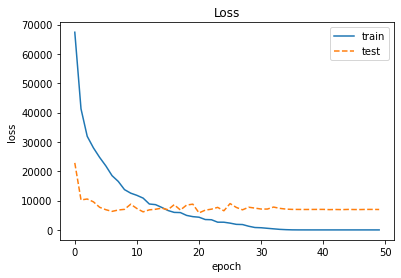

In [32]:
plt.title("Loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(train_loss_list, '-', label = "train")
plt.plot(test_loss_list, '--', label = "test")
plt.legend()
plt.savefig('loss.png', dpi=300)

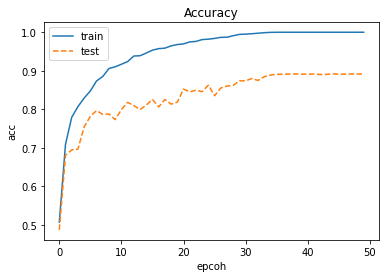

In [33]:
plt.title("Accuracy")
plt.xlabel("epcoh")
plt.ylabel("acc")
plt.plot(train_acc_list, "-", label = "train")
plt.plot(test_acc_list, "--", label = "test")
plt.legend()
plt.savefig('accuracy.png', dpi=300)

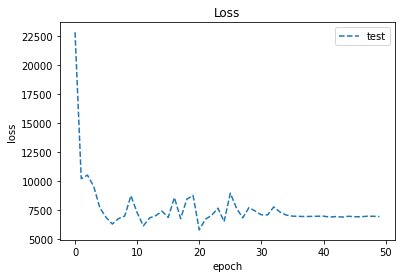

In [35]:
plt.title("Loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(test_loss_list, '--', label = "test")
plt.legend()
plt.savefig('loss_test.png', dpi=300)

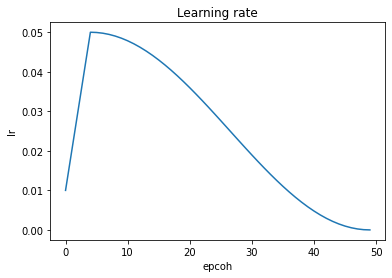

In [34]:
plt.title("Learning rate")
plt.xlabel("epcoh")
plt.ylabel("lr")
plt.plot(lr_list)
plt.savefig('learningrate.png', dpi=300)

In [ ]:
sum(time_list) / len(time_list)

21.105367965698242

(50000, 10000)